<a href="https://colab.research.google.com/github/sabaronett/REBOUNDxPaper/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>REBOUNDx Interactive Demo<h1>

*This notebook is designed for [Google Colab](https://colab.research.google.com/github/sabaronett/REBOUNDxPaper/blob/master/colab_demo.ipynb); visit [Welcome To Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb) to learn more.*

Below are a few quick and interactive demos of **REBOUNDx**'s new features and effects introduced in [*Baronet et al. (2021)*](https://arxiv.org/abs/2101.12277). You can find more resources and example notebooks at our paper's [GitHub repository](https://github.com/sabaronett/REBOUNDxPaper), and at [REBOUND](https://rebound.readthedocs.io/en/latest/) and [REBOUNDx](https://reboundx.readthedocs.io/en/latest/).

## Stellar Evolution

This example shows how to change a particle's mass by interpolating time-series data during a REBOUND simulation.

First let's set up a simple Sun-Earth system.

In [27]:
!pip install -q rebound
import rebound

def makesim():
  sim = rebound.Simulation()        # create simulation object
  sim.units = ('yr', 'AU', 'Msun')  # set sim's units
  sim.add(m=1.)                     # add Sun (1 Msun)
  sim.add(a=1.)                     # add Earth at 1 au
  sim.integrator = 'whfast'         # set integrator
  return sim

Before we change anything, let's integrate this system for 10,000 and verify Earth's semi-major axis does not change.

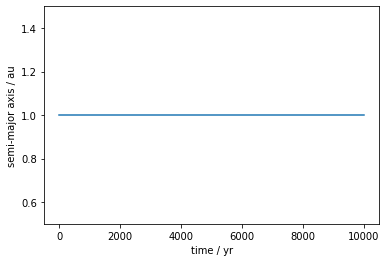

CPU times: user 4.65 s, sys: 2.6 ms, total: 4.65 s
Wall time: 4.65 s


In [28]:
%%time
import numpy as np
import matplotlib.pyplot as plt

sim = makesim()                     # initialize sim
ps = sim.particles                  # retrieve array of particle objects
Nout = 1000                         # set total # of outputs
times = np.linspace(0, 1e4, Nout)   # Nout evenly spaced intervals from 0 to 10K
a = np.zeros(Nout)                  # array for Earth's semi-major axis

for i, t in enumerate(times):       # loop through times
  sim.integrate(t)                  # advance sim to next output time
  a[i] = ps[1].a                    # store Earth's current semi-major axis

plt.plot(times, a)                  # plot Earth's semi-major axis vs. time
plt.xlabel('time / yr')
plt.ylabel('semi-major axis / au')
plt.ylim(0.5, 1.5)
plt.show()

Now let's define a time series of the Sun's mass, consisting of just two equal-sized arrays. The following 5 values correspond to an exponential mass loss rate (e-folding timescale) of $10^4$ years. We then create an `Interpolator` object for the parameter set and pass our arrays as arguments. Before moving on, we plot the mass loss data for good measure.

In [34]:
!pip install reboundx
import reboundx

sim = makesim()                                        # reinitialize sim
rebx = reboundx.Extras(sim)                            # initialize REBOUNDx
mtimes = np.asarray([0, 2500, 5000, 7500, 10000])      # define time series
masses = np.asarray([1., 0.77880078307, 0.60653065971, # series of masses
                     0.47236655274, 0.36787944117])
starmass = reboundx.Interpolator(rebx, mtimes, masses, # create interp. obj.
                                 'spline')

plt.plot(mtimes, masses)                                     # plot mass loss
plt.xlabel('time / yr')
plt.ylabel('mass / Msun')
# plt.ylim(0.5, 1.5)
plt.show()

OSError: ignored

## Tidal Drag